In [78]:
!pip install tensorflow_hub

     |████████████████████████████████| 108 kB 1.7 MB/s eta 0:00:01


In [6]:
# !pip install tensorflow==2.6.1
# ! pip install matplotlib
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install tensorflow_hub

In [76]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [9]:
import spacy
nlp=spacy.load('en_core_web_sm')
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [10]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,Unnamed: 0,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,10788,Indian Relish Recipe,91,https://images.media-allrecipes.com/userphotos...,CINDYLEE65,5 m,30 m,4 h 35 m,"bell pepper,onion,white wine,white sugar,red p...","In a medium saucepan over medium heat, mix tog...",24180
1,6834,My Meatloaf Recipe,127,https://images.media-allrecipes.com/userphotos...,Marian Turgeon,10 m,1 h 20 m,1 h 30 m,"ground beef,ketchup,onion,leftovers,tea,water,...",Preheat oven to 425 degrees F (220 degrees C)....,16511
2,7995,Baked Scalloped Potatoes Recipe,172,https://images.media-allrecipes.com/userphotos...,Denyse,15 m,1 h 15 m,1 h 30 m,"potato,mushroom,milk,onion,black pepper",Preheat oven to 375 degrees F (190 degrees C)...,18346
3,4108,Jicama Pie Recipe,3,https://images.media-allrecipes.com/userphotos...,MANDR,X,X,X,"1 jicama, peeled and shredded,sherry,water,whi...","Combine shredded jicama, sherry and water in a...",12647
4,53,'Ron''s Fruit Bread Recipe ',4,https://images.media-allrecipes.com/userphotos...,Ron Evers,5 m,3 h,3 h 5 m,"water,egg,milk,honey,margarine,salt,bread,flou...",Place ingredients in order suggested by your m...,7077


In [11]:
all_ingredients = []
for ing in df_train.Ingredients:
    all_ingredients += ing.split(',')
all_ingredients = pd.Series(all_ingredients)
all_ingredients.value_counts()[:50]

white sugar      3996
egg              3889
salt             3636
butter           3578
flour            3331
vanilla          2494
onion            2240
milk             2192
water            2125
garlic           1700
brown sugar      1356
chocolate        1340
pepper           1268
chicken          1190
baking soda      1176
black pepper     1169
cinnamon         1140
vegetable oil    1088
sugar            1039
baking powder    1016
tomato            964
olive             925
walnut            796
cream cheese      779
lemon juice       734
bell pepper       706
celery            676
potato            645
shortening        604
pecan             583
sour cream        580
cream             572
mushroom          560
bread             542
carrot            540
cheddar           525
nutmeg            517
parsley           507
lemon             504
almond            477
mayonnaise        470
vinegar           448
green onion       436
raisin            435
margarine         431
coconut   

In [12]:
# ingredients length
all_ingredients.map(lambda x: len(x.split())).value_counts(normalize=True)

1     0.760453
2     0.233420
3     0.001699
4     0.001589
5     0.000971
6     0.000861
7     0.000692
8     0.000231
9     0.000049
10    0.000012
11    0.000012
12    0.000012
dtype: float64

In [13]:
# Most ingredients (99.3%) have 1 or 2 words, so we only check up to 2 consecutive words to match exactly

# Maybe it wold be a good idea to ignore the first word of an ingredient when trying to match (e.g. red pepper may not exist in the text, but pepper may exist.)

In [14]:
def _match_ingredients(tokens, ingredients):
    words = [token.text for token in tokens]
    ann = ['O'] * len(words)
    for i in range(len(words)):
        word = words[i]
        lemm = tokens[i].lemma_
        if word in ingredients or lemm in ingredients:
            ann[i] = 'B-INGREDIENT'
        elif i+1 < len(words):
            nw = words[i+1]
            nl = tokens[i+1].lemma_
            if f'{word} {nw}' in ingredients or f'{lemm} {nl}' in ingredients or f'{word} {nl}' in ingredients or f'{lemm} {nw}' in ingredients:
                ann[i] = 'B-INGREDIENT'
                ann[i+1] = 'I-INGREDIENT'
    return list(zip(words, ann))

def annotate_sentence(row):
    text = row.Directions if pd.notna(row.Directions) else ''
    doc = nlp(text)
    tokens = [token for token in doc]
    
    ingredients = set(row.Ingredients.split(','))
    ann_sentence = _match_ingredients(tokens, ingredients)
    
    return ann_sentence
    
annotate_sentence(df_train.iloc[0])

[('In', 'O'),
 ('a', 'O'),
 ('medium', 'O'),
 ('saucepan', 'O'),
 ('over', 'O'),
 ('medium', 'O'),
 ('heat', 'O'),
 (',', 'O'),
 ('mix', 'O'),
 ('together', 'O'),
 ('red', 'O'),
 ('bell', 'B-INGREDIENT'),
 ('peppers', 'I-INGREDIENT'),
 (',', 'O'),
 ('onion', 'B-INGREDIENT'),
 (',', 'O'),
 ('white', 'B-INGREDIENT'),
 ('wine', 'I-INGREDIENT'),
 ('vinegar', 'O'),
 (',', 'O'),
 ('sugar', 'O'),
 ('and', 'O'),
 ('crushed', 'O'),
 ('red', 'B-INGREDIENT'),
 ('pepper', 'I-INGREDIENT'),
 ('flakes', 'O'),
 ('.', 'O'),
 ('Bring', 'O'),
 ('to', 'O'),
 ('a', 'O'),
 ('boil', 'O'),
 (',', 'O'),
 ('then', 'O'),
 ('reduce', 'O'),
 ('heat', 'O'),
 ('to', 'O'),
 ('simmer', 'O'),
 ('.', 'O'),
 ('Stirring', 'O'),
 ('occasionally', 'O'),
 (',', 'O'),
 ('cook', 'O'),
 ('30', 'O'),
 ('minutes', 'O'),
 (',', 'O'),
 ('or', 'O'),
 ('until', 'O'),
 ('thickened', 'O'),
 ('.', 'O'),
 ('Refrigerate', 'O'),
 ('4', 'O'),
 ('hours', 'O'),
 ('or', 'O'),
 ('overnight', 'O'),
 ('before', 'O'),
 ('serving', 'O'),
 ('.', 'O'

In [15]:
df_train.iloc[0].Ingredients

'bell pepper,onion,white wine,white sugar,red pepper'

In [16]:
df_train['ann_sentence'] = df_train.apply(annotate_sentence, axis=1)
df_train.head()

,Unnamed: 0,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID,ann_sentence
0,10788,Indian Relish Recipe,91,https://images.media-allrecipes.com/userphotos...,CINDYLEE65,5 m,30 m,4 h 35 m,"bell pepper,onion,white wine,white sugar,red p...","In a medium saucepan over medium heat, mix tog...",24180,"[(In, O), (a, O), (medium, O), (saucepan, O), ..."
1,6834,My Meatloaf Recipe,127,https://images.media-allrecipes.com/userphotos...,Marian Turgeon,10 m,1 h 20 m,1 h 30 m,"ground beef,ketchup,onion,leftovers,tea,water,...",Preheat oven to 425 degrees F (220 degrees C)....,16511,"[(Preheat, O), (oven, O), (to, O), (425, O), (..."
2,7995,Baked Scalloped Potatoes Recipe,172,https://images.media-allrecipes.com/userphotos...,Denyse,15 m,1 h 15 m,1 h 30 m,"potato,mushroom,milk,onion,black pepper",Preheat oven to 375 degrees F (190 degrees C)...,18346,"[(Preheat, O), (oven, O), (to, O), (375, O), (..."
3,4108,Jicama Pie Recipe,3,https://images.media-allrecipes.com/userphotos...,MANDR,X,X,X,"1 jicama, peeled and shredded,sherry,water,whi...","Combine shredded jicama, sherry and water in a...",12647,"[(Combine, O), (shredded, O), (jicama, O), (,,..."
4,53,'Ron''s Fruit Bread Recipe ',4,https://images.media-allrecipes.com/userphotos...,Ron Evers,5 m,3 h,3 h 5 m,"water,egg,milk,honey,margarine,salt,bread,flou...",Place ingredients in order suggested by your m...,7077,"[(Place, O), (ingredients, O), (in, O), (order..."


In [17]:
df_train.ann_sentence.iloc[2], df_train.Ingredients.iloc[2]

([('Preheat', 'O'),
  ('oven', 'O'),
  ('to', 'O'),
  ('375', 'O'),
  (' ', 'O'),
  ('degrees', 'O'),
  ('F', 'O'),
  ('(', 'O'),
  ('190', 'O'),
  ('degrees', 'O'),
  ('C', 'O'),
  (')', 'O'),
  ('.', 'O'),
  ('Grease', 'O'),
  ('a', 'O'),
  ('2', 'O'),
  ('quart', 'O'),
  ('casserole', 'O'),
  ('dish.**Layer', 'O'),
  ('potatoes', 'B-INGREDIENT'),
  ('and', 'O'),
  ('onions', 'B-INGREDIENT'),
  ('into', 'O'),
  ('the', 'O'),
  ('casserole', 'O'),
  ('dish', 'O'),
  ('.', 'O'),
  ('Combine', 'O'),
  ('soup', 'O'),
  (',', 'O'),
  ('milk', 'B-INGREDIENT'),
  ('and', 'O'),
  ('pepper', 'O'),
  ('in', 'O'),
  ('a', 'O'),
  ('bowl', 'O'),
  (',', 'O'),
  ('then', 'O'),
  ('pour', 'O'),
  ('soup', 'O'),
  ('mixture', 'O'),
  ('over', 'O'),
  ('the', 'O'),
  ('potatoes', 'B-INGREDIENT'),
  ('and', 'O'),
  ('onions', 'B-INGREDIENT'),
  ('.', 'O'),
  (' ', 'O'),
  ('The', 'O'),
  ('soup', 'O'),
  ('mixture', 'O'),
  ('should', 'O'),
  ('almost', 'O'),
  ('cover', 'O'),
  ('the', 'O'),
  ('pot

In [18]:
# from collections import Counter

words_counter = []
for ann_sentence in df_train.ann_sentence:
    words = [pair[0] for pair in ann_sentence]
    words_counter += words
    
words_counter = pd.Series(words_counter)
words_counter.value_counts()

.                          61173
,                          60401
and                        42365
the                        36688
a                          24283
                           ...  
strawberries.**Coarsely        1
cubes.**Use                    1
sweating"--                    1
late                           1
done.**Cut                     1
Length: 13494, dtype: int64

In [19]:
# Unique words
words_counter.unique().shape

(13494,)

In [65]:
# At least 2 appearances
min_freq = 2

counts = words_counter.str.lower().value_counts()

frequent_words = counts[counts >= min_freq].index.tolist()
frequent_words

['.',
 ',',
 'and',
 'the',
 'a',
 'in',
 'to',
 '*',
 ' ',
 'until',
 'degrees',
 'with',
 'for',
 'minutes',
 'of',
 'into',
 'oven',
 '(',
 'or',
 'bowl',
 'mixture',
 'sugar',
 'over',
 'f',
 'heat',
 'stir',
 'mix',
 'add',
 'large',
 'on',
 'medium',
 ')',
 'flour',
 'baking',
 'butter',
 'together',
 'salt',
 '1',
 'inch',
 'c',
 'preheat',
 'water',
 'cream',
 'combine',
 '350',
 'place',
 '175',
 'pour',
 'at',
 'pan',
 'is',
 'cool',
 'cheese',
 'cook',
 '2',
 'from',
 'beat',
 'pepper',
 'cup',
 '-',
 'top',
 'well',
 'brown',
 'oil',
 'then',
 '10',
 'remove',
 'chicken',
 'preheated',
 'milk',
 'cake',
 'eggs',
 'cover',
 'egg',
 '1/2',
 'about',
 "'",
 'vanilla',
 'dough',
 'bake',
 'sauce',
 'onion',
 'set',
 'saucepan',
 'boil',
 'serve',
 'lightly',
 'small',
 'powder',
 'garlic',
 'grease',
 'out',
 'let',
 'cookie',
 'each',
 'juice',
 'are',
 'sprinkle',
 'chocolate',
 'one',
 '5',
 'skillet',
 'prepared',
 '30',
 'before',
 'dish',
 'smooth',
 'remaining',
 'spread

In [21]:
df_train['sentence_len'] = df_train.ann_sentence.map(lambda x: len(x))
df_train.sentence_len.describe()

count    9881.000000
mean      100.762170
std        53.314571
min         0.000000
25%        65.000000
50%        92.000000
75%       125.000000
max       658.000000
Name: sentence_len, dtype: float64

<AxesSubplot:>

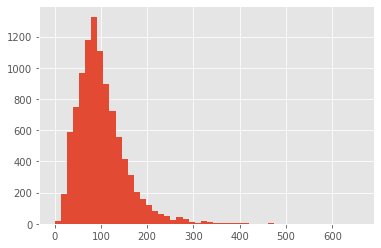

In [22]:
df_train.sentence_len.hist(bins=50)

In [23]:
(df_train.sentence_len < 150).value_counts(normalize=True)

True     0.857201
False    0.142799
Name: sentence_len, dtype: float64

In [24]:
labels_counter = []
for ann_sentence in df_train.ann_sentence:
    labels = [pair[1] for pair in ann_sentence]
    labels_counter += labels
    
labels_counter = pd.Series(labels_counter)
labels_counter.value_counts()

O               905923
B-INGREDIENT     80315
I-INGREDIENT      9393
dtype: int64

In [26]:
labels = ['O', 'B-INGREDIENT', 'I-INGREDIENT']
MAX_LEN = 150 # due to computing power restrictions; however, this is still a reasonable number (fully covers 85% of sentences)


label2id = {label: index for index, label in enumerate(labels)}
id2label = {v:k for k, v in label2id.items()}
label2id, id2label

({'O': 0, 'B-INGREDIENT': 1, 'I-INGREDIENT': 2},
 {0: 'O', 1: 'B-INGREDIENT', 2: 'I-INGREDIENT'})

In [74]:
labels.index('O')

0

In [69]:
word2id = {
    'PadWord': 0,
    'UnkWord': 1,
}
for idx, word in enumerate(frequent_words):
    word2id[word.lower()] = idx + 2

id2word = {v:k for k, v in word2id.items()}

In [71]:
word2id

{'PadWord': 0,
 'UnkWord': 1,
 '.': 2,
 ',': 3,
 'and': 4,
 'the': 5,
 'a': 6,
 'in': 7,
 'to': 8,
 '*': 9,
 ' ': 10,
 'until': 11,
 'degrees': 12,
 'with': 13,
 'for': 14,
 'minutes': 15,
 'of': 16,
 'into': 17,
 'oven': 18,
 '(': 19,
 'or': 20,
 'bowl': 21,
 'mixture': 22,
 'sugar': 23,
 'over': 24,
 'f': 25,
 'heat': 26,
 'stir': 27,
 'mix': 28,
 'add': 29,
 'large': 30,
 'on': 31,
 'medium': 32,
 ')': 33,
 'flour': 34,
 'baking': 35,
 'butter': 36,
 'together': 37,
 'salt': 38,
 '1': 39,
 'inch': 40,
 'c': 41,
 'preheat': 42,
 'water': 43,
 'cream': 44,
 'combine': 45,
 '350': 46,
 'place': 47,
 '175': 48,
 'pour': 49,
 'at': 50,
 'pan': 51,
 'is': 52,
 'cool': 53,
 'cheese': 54,
 'cook': 55,
 '2': 56,
 'from': 57,
 'beat': 58,
 'pepper': 59,
 'cup': 60,
 '-': 61,
 'top': 62,
 'well': 63,
 'brown': 64,
 'oil': 65,
 'then': 66,
 '10': 67,
 'remove': 68,
 'chicken': 69,
 'preheated': 70,
 'milk': 71,
 'cake': 72,
 'eggs': 73,
 'cover': 74,
 'egg': 75,
 '1/2': 76,
 'about': 77,
 "'": 

In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [85]:
def get_features_and_targets(ann_sentences, word2id, label2id, max_len=MAX_LEN):
    sentences, labels = [], []
    for ann_sentence in ann_sentences:
        word_indices, label_indices = [], []
        for word, label in ann_sentence:
            if word.lower() in word2id:
                word_idx = word2id[word.lower()]
            else:
                word_idx = word2id['UnkWord']
            label_idx = label2id[label]
            word_indices.append(word_idx)
            label_indices.append(label_idx)
        sentences.append(word_indices)
        labels.append(label_indices)
        
    padded_sentences = pad_sequences(sentences, max_len, padding='post')
    padded_labels = pad_sequences(labels, max_len, padding='post')
    return padded_sentences, padded_labels
    
#     return sentences, labels

In [102]:
X_train, y_train = get_features_and_targets(df_train.ann_sentence, word2id, label2id)

In [103]:
X_train.shape, y_train.shape

((9881, 150), (9881, 150))

In [104]:
X_train

array([[  7,   6,  32, ...,   0,   0,   0],
       [ 42,  18,   8, ...,   0,   0,   0],
       [ 42,  18,   8, ...,   0,   0,   0],
       ...,
       [ 64, 195,   4, ...,   0,   0,   0],
       [219, 801, 973, ...,   0,   0,   0],
       [  7,   6,  30, ...,   0,   0,   0]], dtype=int32)

In [97]:
EMBEDDING_DIM = 100

embeddings_index = {}
f = open('data/glove.6B/glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word2id), EMBEDDING_DIM))
for word, idx in word2id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [99]:
embedding_matrix.shape

(5938, 100)

In [112]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0], reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [113]:
train_dataset

<BatchDataset shapes: ((32, 150), (32, 150)), types: (tf.int32, tf.int32)>

In [119]:
import tensorflow as tf
from tensorflow.keras import layers

class MyNER(tf.keras.Model):
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, embed_weights, num_labels):
        super(MyNER, self).__init__() 
        self.embedding = layers.Embedding(input_dim=embed_input_dim, 
        output_dim=embed_output_dim, weights=embed_weights,    
        input_length=max_seq_len, trainable=False, mask_zero=True)

        self.bilstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        self.dense = layers.Dense(num_labels)
        
    def call(self, inputs):
        x = self.embedding(inputs) # batchsize, max_seq_len, embedding_output_dim
        
        x = self.bilstm(x) # batchsize, max_seq_len, hidden_dim_bilstm
        
        logits = self.dense(x) #batchsize, max_seq_len, num_labels
        
        return logits

In [120]:
model = MyNER(
    max_seq_len=MAX_LEN,
    embed_input_dim=len(word2id),
    embed_output_dim=EMBEDDING_DIM,
    embed_weights=[embedding_matrix],
    num_labels=len(label2id)
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [121]:
train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
valid_loss_metric = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)

def train_step_fn(sentences_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits = model(sentences_batch)
        loss = criterion(labels_batch, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
    return loss, logits

def valid_step_fn(sentences_batch, labels_batch):
    logits = model(sentences_batch)
    loss = criterion(labels_batch, logits)
    return loss, logits

In [172]:
df_valid = pd.read_csv('data/valid.csv')
df_valid['ann_sentence'] = df_valid.apply(annotate_sentence, axis=1)
X_valid, y_valid = get_features_and_targets(df_valid.ann_sentence, word2id, label2id)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=X_valid.shape[0], reshuffle_each_iteration=False)
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [141]:
from tqdm import tqdm

EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    for sentences_batch, labels_batch in train_dataset:
        loss, logits = train_step_fn(sentences_batch, labels_batch)
        train_loss_metric(loss)
        
    print(train_loss_metric.result().numpy())
    train_loss_metric.reset_states()
    
    for sentences_batch, labels_batch in valid_dataset:
        loss, logits = valid_step_fn(sentences_batch, labels_batch)
        valid_loss_metric.update_state(loss)
    print(valid_loss_metric.result().numpy())
    valid_loss_metric.reset_states()

                                     
# model.save_weights(f"{args.output}/model_weights",save_format='tf')

  0%|          | 0/5 [00:00<?, ?it/s]

0.090518914


 20%|██        | 1/5 [05:37<22:30, 337.63s/it]

0.044693112
0.035315286


 40%|████      | 2/5 [11:14<16:52, 337.35s/it]

0.029565377
0.02662914


 60%|██████    | 3/5 [16:55<11:18, 339.06s/it]

0.023761459
0.02301983


 80%|████████  | 4/5 [22:40<05:41, 341.25s/it]

0.02128152
0.020875838


100%|██████████| 5/5 [28:22<00:00, 340.53s/it]

0.019503318


In [142]:
model

In [150]:
model.save_weights(f"bilstm_model_0/weights",save_format='tf')

In [199]:
settings = {
    'max_seq_len': MAX_LEN,
    'embed_input_dim': len(word2id),
    'embed_output_dim': EMBEDDING_DIM,
    'embed_weights': [embedding_matrix],
    'num_labels': len(label2id)
}

mappings = {
    'word2id': word2id,
    'id2word': id2word,
    'label2id': label2id,
    'id2label': id2label,
}

In [195]:
import pickle

with open('bilstm_model_0/settings.pkl', 'wb') as f_out:
    pickle.dump(settings, f_out)

In [200]:
with open('bilstm_model_0/mappings.pkl', 'wb') as f_out:
    pickle.dump(mappings, f_out)

In [144]:
# Evaluation

In [146]:
# !pip install seqeval

In [185]:
import seqeval
from seqeval.metrics import classification_report

In [173]:
true_labels = []
pred_labels = []
for sentences_batch, labels_batch in valid_dataset:
    logits = model(sentences_batch)
    probs = tf.nn.softmax(logits)
    preds = tf.argmax(probs, axis=2)
    true_labels.append(np.asarray(labels_batch))
    pred_labels.append(np.asarray(preds))
    

In [157]:
pred_labels[0].shape

(32, 150)

In [158]:
def indices_to_labels(indices, id2label):
    labels = []
    for batch in indices:
        for sentence in batch:
            label = [id2label[idx] for idx in sentence]
            labels.append(label)
    return labels

In [179]:
y_pred = indices_to_labels(pred_labels, id2label)
y_true = indices_to_labels(true_labels, id2label)

In [191]:
report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

  INGREDIENT     0.9190    0.9002    0.9095      9054

   micro avg     0.9190    0.9002    0.9095      9054
   macro avg     0.9190    0.9002    0.9095      9054
weighted avg     0.9190    0.9002    0.9095      9054

